# Are daily step counts and the number of tweets sent per day correlated?
They probably aren't but it's not unreasonable to think about it. After all, time spent on social media is time missing for being physically active and vice versa. Unless you're one of those people who walk around while tweeting (don't, it's dangerous!).

![](http://www.kiss1023.ca/wp-content/uploads/sites/10/2017/07/textwalkpole.gif)

But let's get started with our analysis. To do so we need to combine two data sources which you need to have in your Open Humans account:
1. Your [Fitbit](https://www.openhumans.org/activity/fitbit-connection) account
2. Your [Twitter archive](https://www.openhumans.org/activity/twitter-archive-analyzer/)

With that out of the way we can start to load all of the Python dependencies we need:

In [1]:
import os
import json
import requests
from datetime import datetime
from collections import defaultdict
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tempfile
import zipfile
import pytz
import io
import sys
from textblob import TextBlob
import emoji


# sets the axis label sizes for seaborn
rc={'font.size': 14, 'axes.labelsize': 14, 'legend.fontsize': 14.0, 
    'axes.titlesize': 14, 'xtick.labelsize': 14, 'ytick.labelsize': 14}
sns.set(rc=rc)

## Processing the Twitter archive data
All the functions are already provided by http://twarxiv.org and we just copied the functions from there. It will basically take a zipped archive from a URL and return a nicely formatted `pandas` dataframe. Let's just take these as given for now:

In [2]:
# THIS CODE BELOW IS COPIED FROM TWARXIV.ORG AS IT ALREADY DOES EXACTLY WHAT WE WANT FOR READING IN THE DATA

# READ JSON FILES FROM TWITTER ARCHIVE!

def check_hashtag(single_tweet):
    '''check whether tweet has any hashtags'''
    return len(single_tweet['entities']['hashtags']) > 0


def check_media(single_tweet):
    '''check whether tweet has any media attached'''
    return len(single_tweet['entities']['media']) > 0


def check_url(single_tweet):
    '''check whether tweet has any urls attached'''
    return len(single_tweet['entities']['urls']) > 0


def check_retweet(single_tweet):
    '''
    check whether tweet is a RT. If yes:
    return name & user name of the RT'd user.
    otherwise just return nones
    '''
    if 'retweeted_status' in single_tweet.keys():
        return (single_tweet['retweeted_status']['user']['screen_name'],
                single_tweet['retweeted_status']['user']['name'])
    else:
        return (None, None)


def check_coordinates(single_tweet):
    '''
    check whether tweet has coordinates attached.
    if yes return the coordinates
    otherwise just return nones
    '''
    if 'coordinates' in single_tweet['geo'].keys():
        return (single_tweet['geo']['coordinates'][0],
                single_tweet['geo']['coordinates'][1])
    else:
        return (None, None)


def check_reply_to(single_tweet):
    '''
    check whether tweet is a reply. If yes:
    return name & user name of the user that's replied to.
    otherwise just return nones
    '''
    if 'in_reply_to_screen_name' in single_tweet.keys():
        name = None
        for user in single_tweet['entities']['user_mentions']:
            if user['screen_name'] == single_tweet['in_reply_to_screen_name']:
                name = user['name']
                break
        return (single_tweet['in_reply_to_screen_name'], name)
    else:
        return (None, None)


def create_dataframe(tweets):
    '''
    create a pandas dataframe from our tweet jsons
    '''

    # initalize empty lists
    utc_time = []
    longitude = []
    latitude = []
    hashtag = []
    media = []
    url = []
    retweet_user_name = []
    retweet_name = []
    reply_user_name = []
    reply_name = []
    text = []
    # iterate over all tweets and extract data
    for single_tweet in tweets:
        utc_time.append(datetime.strptime(single_tweet['created_at'],
                                                   '%Y-%m-%d %H:%M:%S %z'))
        coordinates = check_coordinates(single_tweet)
        latitude.append(coordinates[0])
        longitude.append(coordinates[1])
        hashtag.append(check_hashtag(single_tweet))
        media.append(check_media(single_tweet))
        url.append(check_url(single_tweet))
        retweet = check_retweet(single_tweet)
        retweet_user_name.append(retweet[0])
        retweet_name.append(retweet[1])
        reply = check_reply_to(single_tweet)
        reply_user_name.append(reply[0])
        reply_name.append(reply[1])
        text.append(single_tweet['text'])
    # convert the whole shebang into a pandas dataframe
    dataframe = pd.DataFrame(data={
                            'utc_time': utc_time,
                            'latitude': latitude,
                            'longitude': longitude,
                            'hashtag': hashtag,
                            'media': media,
                            'url': url,
                            'retweet_user_name': retweet_user_name,
                            'retweet_name': retweet_name,
                            'reply_user_name': reply_user_name,
                            'reply_name': reply_name,
                            'text': text
    })
    return dataframe


def read_files(zip_url):
    tf = tempfile.NamedTemporaryFile()
    print('downloading files')
    tf.write(requests.get(zip_url).content)
    tf.flush()
    zf = zipfile.ZipFile(tf.name)
    print('reading index')
    with zf.open('data/js/tweet_index.js', 'r') as f:
        f = io.TextIOWrapper(f)
        d = f.readlines()[1:]
        d = "[{" + "".join(d)
        json_files = json.loads(d)
    data_frames = []
    print('iterate over individual files')
    for single_file in json_files:
        print('read ' + single_file['file_name'])
        with zf.open(single_file['file_name']) as f:
            f = io.TextIOWrapper(f)
            d = f.readlines()[1:]
            d = "".join(d)
            tweets = json.loads(d)
            df_tweets = create_dataframe(tweets)
            data_frames.append(df_tweets)
    return data_frames


def create_main_dataframe(zip_url='http://ruleofthirds.de/test_archive.zip'):
    print('reading files')
    dataframes = read_files(zip_url)
    print('concatenating...')
    dataframe = pd.concat(dataframes)
    dataframe = dataframe.sort_values('utc_time', ascending=False)
    dataframe = dataframe.set_index('utc_time')
    dataframe = dataframe.replace(to_replace={
                                    'url': {False: None},
                                    'hashtag': {False: None},
                                    'media': {False: None}
                                    })
    return dataframe


# Downloading & importing Fitbit/Twitter data
Now that we have set up all the functions we need for importing the Twitter data, let's grab the data itself. We're getting our data URLs from Open Humans and import both Twitter & Fitbit data (this might take a while if you have lots of tweets/fitbit data points).

In [3]:
response = requests.get("https://www.openhumans.org/api/direct-sharing/project/exchange-member/?access_token={}".format(os.environ.get('OH_ACCESS_TOKEN')))
user = json.loads(response.content)

has_twitter = False
has_fitbit = False

# get our download URLs
for entry in user['data']:
    if entry['source'] == "direct-sharing-70":
        twitter_data_url = entry['download_url']
        has_twitter = True
    if entry['source'] == "direct-sharing-102":
        fitbit_data_url = entry['download_url']
        has_fitbit = True

if not has_twitter:
    print("YOU NEED TO HAVE SOME TWITTER DATA IN YOUR ACCOUNT TO USE THIS NOTEBOOK")
    print("GO TO http://twarxiv.org TO UPLOAD IT")

if not has_fitbit:
    print("YOU NEED TO HAVE SOME FITBIT DATA IN YOUR ACCOUNT TO USE THIS NOTEBOOK")
    print("GO TO https://www.openhumans.org/activity/fitbit-connection/ TO UPLOAD IT")
    
# read the twitter data
twitter_data = create_main_dataframe(zip_url=twitter_data_url)

# read the fitbit data
fitbit_data_raw = requests.get(fitbit_data_url).content
fitbit_data = json.loads(fitbit_data_raw)

reading files
downloading files
reading index
iterate over individual files
read data/js/tweets/2018_03.js
read data/js/tweets/2018_02.js
read data/js/tweets/2018_01.js
read data/js/tweets/2017_12.js
read data/js/tweets/2017_11.js
read data/js/tweets/2017_10.js
read data/js/tweets/2017_09.js
read data/js/tweets/2017_08.js
read data/js/tweets/2017_07.js
read data/js/tweets/2017_06.js
read data/js/tweets/2017_05.js
read data/js/tweets/2017_04.js
read data/js/tweets/2017_03.js
read data/js/tweets/2017_02.js
read data/js/tweets/2017_01.js
read data/js/tweets/2016_12.js
read data/js/tweets/2016_11.js
read data/js/tweets/2016_10.js
read data/js/tweets/2016_09.js
read data/js/tweets/2016_08.js
read data/js/tweets/2016_07.js
read data/js/tweets/2016_06.js
read data/js/tweets/2016_05.js
read data/js/tweets/2016_04.js
read data/js/tweets/2016_03.js
read data/js/tweets/2016_02.js
read data/js/tweets/2016_01.js
read data/js/tweets/2015_12.js
read data/js/tweets/2015_11.js
read data/js/tweets/2015_

Let's convert our raw *Fitbit* data into a `pandas` dataframe - this will make it much easier to plot our data and unite it with the `Twitter` data at the end:

In [4]:
date = []
steps = []

for year in fitbit_data['tracker-steps'].keys():
    for entry in fitbit_data['tracker-steps'][year]['activities-tracker-steps']:
        date.append(entry['dateTime'])
        steps.append(entry['value'])
        
fitbit_steps = pd.DataFrame(data={
                'date':date,
                'steps': steps})
fitbit_steps['date'] = pd.to_datetime(fitbit_steps['date'])
fitbit_steps = fitbit_steps.set_index('date')

This gives us the daily `steps` along with the `date`, nicely formatted. We can now prepare our twitter-data and calculate the number of `tweets_per_day` for our final plots:

In [5]:
twitter_data['date'] = twitter_data.index.date
tweets_per_day = twitter_data['date'].value_counts()
twitter_mean = twitter_data.groupby(twitter_data.index.date).mean()
twitter_mean = twitter_mean.join(tweets_per_day)
twitter_mean['tweets_per_day'] = twitter_mean['date']

With that out of the way we can join our data and join our two `twitter_mean` and `fitbit_steps` dataframes into one. To make sure to not bias our data analysis for dates during which we didn't collect any data we remove all days during which we didn't record `steps`.

In [6]:
joined_data = twitter_mean.join(fitbit_steps,how='right')
joined_data['steps'] = joined_data['steps'].apply(int)
joined_data = joined_data[joined_data['steps'] != 0]
joined_data['year'] = joined_data.index.year

In [7]:
joined_data.head()

,hashtag,media,url,date,tweets_per_day,steps,year
date,,,,,,,
2013-01-01,1.0,NaN,1.0,19.0,19.0,10978,2013
2013-01-02,NaN,1.0,1.0,43.0,43.0,11639,2013
2013-01-03,NaN,NaN,1.0,25.0,25.0,14943,2013
2013-01-04,NaN,NaN,1.0,18.0,18.0,16222,2013
2013-01-05,1.0,1.0,1.0,24.0,24.0,14165,2013


Let's now plot our daily step counts and number of tweets:

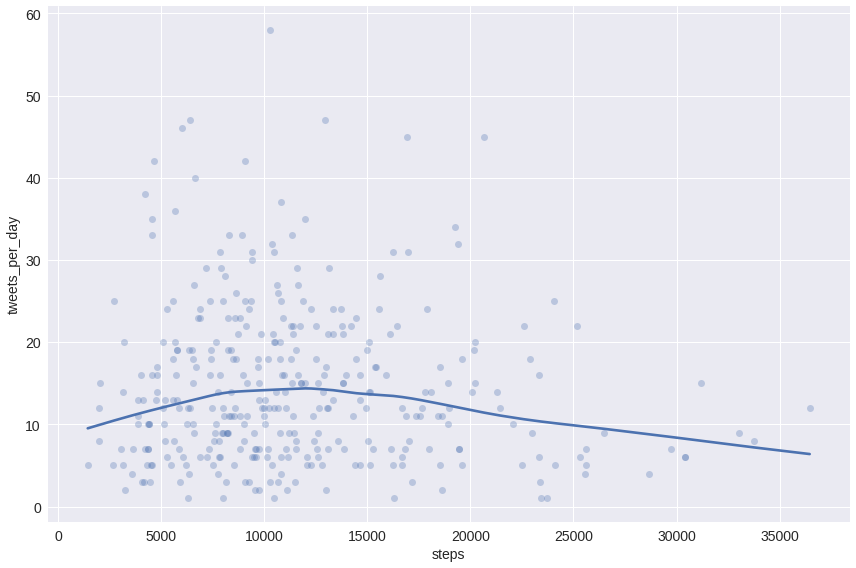

In [8]:
sns.lmplot(x="steps", 
           y="tweets_per_day", 
           data=joined_data[joined_data.index.year == 2014],
           lowess=True,
           size=8,
           aspect=1.5,
           scatter_kws={'alpha':0.3})

It looks like there is some correlation between the number of daily steps and the number of daily tweets: On days with more steps there are less tweets. But this might be a result of tweeting more/less over time in general or walking more/less over time. So let's break it down into yearly numbers:

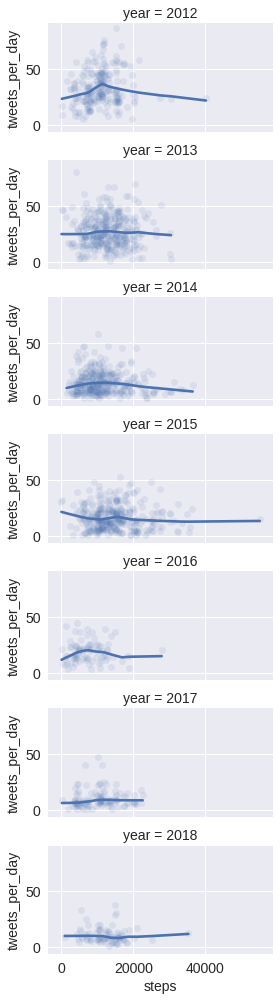

In [9]:
sns.lmplot(x="steps", y="tweets_per_day", row='year', data=joined_data,lowess=True,size=2,aspect=2,scatter_kws={'alpha':0.1})

This looks different. First of all we see that the number of daily tweets drops a lot from `2012` to `2018`. And additionally we see that the number of daily steps is a lot lower for `2016` and `2017`. 

Which makes sense: 
1. For much of 2015/2016 I didn't wear any Fitbit but rather only used the iPhone app to import data.
2. I also happened to write my PhD thesis during those years, so I moved and tweeted less. 😂

Does your Twitter activity and physical activity correlate?